# NPT ensemble

## TL;DR

- In NPT-MD simulations, pressure and temperature are controlled and remain constant once the system reaches equilibrium. There are two common pressure control (barostat) methods available in ASE: the Parrinello-Rahman method and the Berendsen method.
- Typical applications include simulations of thermal expansion, phase transitions, and pressurization of solids and fluids.
- In the Parrinello-Rahman method, all degrees of freedom of the simulation cell are variable, and the control parameter (`pfactor`) must be set appropriately.
- Berendsen barostat, like Berendsen thermostat, can control pressure efficiently for convergence; Berendsen barostat can be calculated in two modes: with fixed cell angles and independently variable cell lengths, or with fixed cell length ratios. `compressibility` must be properly set as an input parameter.

In this section, we will discuss a method to create an equilibrium state in which both pressure and temperature are constant. The pressure control mechanism is generally referred to as **barostat**, and is used in conjunction with the thermostat method described in section 6-2 to generate a state distribution called an isothermal-isobaric ensemble (also known as NPT). 

Phenomena that can be studied, in principle, in NPT-MD simulations include

- Coefficient of thermal expansion of solids
- Prediction of melting point
- Phase transitions in solids
- Density prediction of fluids (gases and liquids)

etc.

The reason why the word "in principle" is used is that the reproducibility of these phenomena depends greatly on the accuracy of the force field used in the calculation, and in particular, it is known to be very difficult to predict intermolecular forces and fluid states that depend on small energy differences. 
In this tutorial, we will learn about NPT-MD through the case study of solids, which are considered to have relatively high accuracy.

First, we will review the [NPT-MD methods implemented in ASE](https://wiki.fysik.dtu.dk/ase/ase/md.html#module-ase.md.npt) that we will use in this tutorial. 
There are three types of implementations available for ASE

| Class | Ensemble | Parameter | thermostat | barostat | description |
|----------|----------|-------------|------|------|----------|
| NPT | NPT | time constant ($\tau_t$), pressure factor (*pfactor*) | Nosé–Hoover|Parrinello-Rahman| セルの全All degrees of freedom of the cell are variable and controllable |
| NPTBerendsen | NPT | $\tau_t$,$\tau_P$,$\beta_T$ | Berendsen|Berendsen| Cell shape is maintained and only volume changes |
| InhomogeneousBerendsen | NPT | $\tau_t$,$\tau_P$,$\beta_T$ | Berendsen|Berendsen| Cell angles are preserved, but pressure anisotropy can be taken into account |

The second and third methods in the table are essentially the same Berendsen barostat. (The third method, `InhomogeneousBerendsen`, is not mentioned in the ASE manual, but is defined as a class within ASE along with `NPTBerendsen`.) 
Thus, there are only two methods available within the ASE framework: the Parrinello-Rahman method and the Berendsen method. 
The heat bath itself uses the methods described in section 6-2, so the characteristics of these heat bath methods should be carefully considered.

Let us first look at the Parrinello-Rahman method, which has relatively high system flexibility and versatility.

## Equations of motion for the Parrinello-Rahman method

The Parrinello-Rahman method is a so-called extended system calculation method, which assumes that the system under consideration is hypothetically connected to an external system of constant temperature and pressure, as in the Nosé-Hoover heat bath method. In this case, the equations of motion are written as follows (For details of the derivation, please refer to references [1-3]).

$$ \dot{\mathbf{x}_i} = \mathbf{p}_i/m_i + \eta(\mathbf{x}_i-\mathbf{R}_o) $$

$$ \dot{\mathbf{p}_i} = \mathbf{F_i}-(\eta+\zeta)\mathbf{p}_i $$

$$ \dot{\zeta} = \frac{1}{\tau_T^2}\left(\frac{T(t)}{T_o}-1\right)-3\eta\zeta $$

$$ \dot{s} = 3(N-1) s\zeta $$

$$ \dot{\mathbf{\eta}} = \frac{V}{\tau_P^2Nk_BT_o}\left(\mathbf{P(t)}-P_o\mathbf{I}\right)+3\frac{\tau_T^2}{\tau_P^2}\zeta^2\mathbf{I}$$

$$ \dot{\mathbf{h}}=\mathbf{\eta}\mathbf{h} $$

Besides the terms for the Nosé-Hoover heat bath, we have the pressure control time constant $\tau_P$, the system center of mass $R_o$, the target external pressure $P_o$, and the simulation cell volume $V$. 
The $\eta$ is the variable for the pressure control degrees of freedom. 
$\mathbf{h} = (\mathbf{a}, \mathbf{b}, \mathbf{c})$ and $\mathbf{a},\mathbf{b},\mathbf{c}$ are cell vectors defining each edge of the simulation cell, respectively.

In addition to temperature $T_o$ and pressure $P_o$, there are two other values that the user must set in the above equation: $\tau_T$ and $\tau_P$. First, the case where $\tau_T$ and $\tau_P$ are simply set to random values is shown below. Here $\tau_T$ is set to 20 fsec. Although $\tau_P$ is not specified directly, the value called `pfactor` is $\tau_P^2B$. The $B$ refers to the bulk modulus, and this value must be calculated and specified in advance. However, since the exact value of $\tau_P$ itself is not known in advance, there is no way to specify `pfactor`. Also, the value of $B$ cannot be calculated for anisotropic structures or when different types of materials coexist in the system. Therefore, we will set an approximate value of `pfactor` to examine the behavior of the barostat. As mentioned in the following example, at least for crystalline metal systems, a value on the order of about 10$^6$ GPa$\cdot$fs$^2$ to 10$^7$ GPa$\cdot$fs$^2$ seems to give good convergence and stability in the calculation. For other materials, it is recommended to play with the value of `pfactor` and check the behavior of the volume change as a preliminary study.

## Calculation example: Coefficient of thermal expansion

Now, we will use the Nosé-Hoover thermostat and the Parrinello-Rahman barostat ([ASE's NPT class](https://wiki.fysik.dtu.dk/ase/ase/ md.html#module-ase.md.npt)) to compute the coefficient of thermal expansion of a solid as an example. The system is equilibrated at temperatures of given increment, and the thermal expansion coefficient is calculated from the average value of the lattice constant at each temperature.

For simplicity, we will use fcc-Cu for this calculation. A sample script is shown below. 
The temperature is varied from 200 K to 1000 K in 100 K interval and the external pressure is set to 1 bar. The structure is fcc-Cu extended to 3x3x3 unit cells with 108 atoms. 
In the example, the ASAP3-EMT force field is used for speed, but the same scheme can be used with PFP. The time step size is set to 1 fs, and the 20 ps simulation is found to be sufficient to reach equilibrium.

In [1]:
import ase
from ase.build import bulk
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution,Stationary
from ase.md.npt import NPT
from ase.md import MDLogger
from ase import units
from time import perf_counter

calc_type = "EMT"
# calc_type = "PFP"

if calc_type == "EMT":
    # ASAP3-EMT calculator
    from asap3 import EMT
    calculator = EMT()
elif calc_type == "PFP":
    # PFP calculator
    from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode
    from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
    estimator = Estimator(model_version="v2.0.0",calc_mode=EstimatorCalcMode.CRYSTAL_U0)
    calculator = ASECalculator(estimator)
else:
    raise ValueError(f"Wrong calc_type = {calc_type}!")


# Set up a crystal
atoms_in = bulk("Cu",cubic=True)
atoms_in *= 3
atoms_in.pbc = True
print("atoms_in = ",atoms_in)

# input parameters
time_step    = 1.0    # fsec
#temperature = 300    # Kelvin
num_md_steps = 20000 
num_interval = 10

sigma   = 1.0     # External pressure in bar
ttime   = 20.0    # Time constant in fs
pfactor = 2e6     # Barostat parameter in GPa
temperature_list = [200,300,400,500,600,700,800,900,1000]

# Print statements
def print_dyn():
    imd = dyn.get_number_of_steps()
    etot  = atoms.get_total_energy()
    temp_K = atoms.get_temperature()
    stress = atoms.get_stress(include_ideal_gas=True)/units.GPa
    stress_ave = (stress[0]+stress[1]+stress[2])/3.0 
    elapsed_time = perf_counter() - start_time
    print(f"  {imd: >3}   {etot:.3f}    {temp_K:.2f}    {stress_ave:.2f}  {stress[0]:.2f}  {stress[1]:.2f}  {stress[2]:.2f}  {stress[3]:.2f}  {stress[4]:.2f}  {stress[5]:.2f}    {elapsed_time:.3f}")

    
# run MD
for i,temperature in enumerate(temperature_list):
    print("i,temperature = ",i,temperature)

    print(f"sigma = {sigma:.1e} bar")
    print(f"ttime = {ttime:.3f} fs")
    print(f"pfactor = {pfactor:.3f} GPa*fs^2")

    temperature_str = str(int(temperature)).zfill(4)
    output_filename = f"./output/ch6/fcc-Cu_3x3x3_NPT_{calc_type}_{temperature_str}K"
    log_filename = output_filename + ".log"
    traj_filename = output_filename + ".traj"
    print("log_filename = ",log_filename)
    print("traj_filename = ",traj_filename)
    
    atoms = atoms_in.copy()
    atoms.calc = calculator
    
    # Set the momenta corresponding to T=300K
    MaxwellBoltzmannDistribution(atoms, temperature_K=temperature,force_temp=True)
    Stationary(atoms)
    
    dyn = NPT(atoms,
          time_step*units.fs,
          temperature_K = temperature,
          externalstress = sigma*units.bar,
          ttime = ttime*units.fs,
          pfactor = pfactor*units.GPa*(units.fs**2),
          logfile = log_filename,
          trajectory = traj_filename,
          loginterval=num_interval
          )
    
    print_interval = 1000 if calc_type == "EMT" else num_interval
    dyn.attach(print_dyn, interval=print_interval)
    dyn.attach(MDLogger(dyn, atoms, log_filename, header=True, stress=True, peratom=True, mode="a"), interval=num_interval)

    # Now run the dynamics
    start_time = perf_counter()
    print(f"    imd     Etot(eV)    T(K)    stress(mean,xx,yy,zz,yz,xz,xy)(GPa)  elapsed_time(sec)")
    dyn.run(num_md_steps)

atoms_in =  Atoms(symbols='Cu108', pbc=True, cell=[10.83, 10.83, 10.83])
i,temperature =  0 200
sigma = 1.0e+00 bar
ttime = 20.000 fs
pfactor = 2000000.000 GPa*fs^2
log_filename =  ./output/ch6/fcc-Cu_3x3x3_NPT_EMT_0200K.log
traj_filename =  ./output/ch6/fcc-Cu_3x3x3_NPT_EMT_0200K.traj
    imd     Etot(eV)    T(K)    stress(mean,xx,yy,zz,yz,xz,xy)(GPa)  elapsed_time(sec)
  1000   3.978    166.23    0.80  0.81  0.76  0.83  -0.01  0.27  0.04    1.133
  2000   4.698    164.97    0.67  0.61  0.63  0.77  -0.09  0.19  0.04    2.063
  3000   5.725    201.32    0.13  -0.12  0.25  0.28  0.08  -0.07  -0.02    3.005
  4000   6.272    209.89    -0.60  -0.85  -0.19  -0.74  0.09  -0.14  -0.14    3.898
  5000   4.987    194.84    -0.32  -0.15  -0.25  -0.55  0.07  0.02  0.06    4.764
  6000   5.138    194.18    -0.03  0.16  -0.35  0.08  0.18  -0.01  0.43    5.630
  7000   6.007    192.54    0.12  0.35  -0.45  0.45  0.54  -0.11  0.41    6.510
  8000   5.714    213.34    0.58  0.50  0.45  0.78  0.49  -0

A visualization of the results is shown below.

Here, the `read` method has been set to `index="::100"` to visualize the results of interval thinning from the `Trajectory` file.
Although Cu retains its solid structure and is not moving significantly, we can see that there is a change in the cell size due to the vibrational movement.

In [2]:
from ase.io import Trajectory, read
from pfcc_extras.visualize.povray import traj_to_apng
from IPython.display import Image


traj = read("./output/ch6/fcc-Cu_3x3x3_NPT_EMT_0900K.traj", index="::100")
traj_to_apng(traj, f"output/ch6/Fig6-3_fcc-Cu_3x3x3_NPT_EMT_0900K.png", rotation="10x,-10y,0z", clean=True, n_jobs=16)

Image(url="output/ch6/Fig6-3_fcc-Cu_3x3x3_NPT_EMT_0900K.png")

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  10 out of  20 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=16)]: Done  20 out of  20 | elapsed:   10.9s finished


In [3]:
from ase.io import Trajectory, read
from pfcc_extras.visualize.view import view_ngl


traj = read("./output/ch6/fcc-Cu_3x3x3_NPT_EMT_0900K.traj", index="::100")
view_ngl(traj, replace_structure=True)

The time constant $\tau_t$ of the heat bath is 20 fs and the barostat parameter, `pfactor`, is 2e6 GPa$\cdot$fs$^2$. Let's check how the cell volume changes with time during a 20 ps NPT-MD simulation at 300 K to achieve thermal equilibrium under the above calculation conditions. You can analyze the traj file, which is the result of MD simulation at a specific temperature, with the following code.

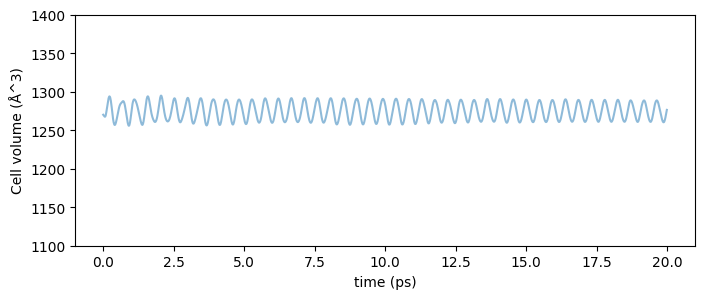

In [4]:
import matplotlib.pyplot as plt
from pathlib import Path
from ase.io import read,Trajectory

time_step = 0.01  # Time step size in ps between each snapshots recorded in traj
traj = Trajectory("./output/ch6/fcc-Cu_3x3x3_NPT_EMT_0300K.traj")

time = [ i*time_step for i in range(len(traj)) ]
volume = [ atoms.get_volume() for atoms in traj ]

# Create graph
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('time (ps)')  # x axis label
ax.set_ylabel('Cell volume (Å^3)')  # y axis label
ax.plot(time,volume, alpha=0.5)
ax.set_ylim([1100,1400])
#plt.savefig("filename.png")  # Set filename to be saved
plt.show()

The time evolution of the cell volume for a 20 ps NPT-MD simulation at 300 K to achieve thermal equilibrium under these calculation conditions is shown below.

<figure style="text-align: center">
    <img src="../assets/ch6/Fig6-3_fcc-Cu_3x3x3_EMT_NPT_vol_vs_t.png"/>
    <figcaption align = "center">Fig.6-3a. Time evolution of cell volume. (fcc-Cu_3x3x3, @300 K and 1 bar)</figcaption>
</figure>
</br>

It is shown that the cell volume oscillates within a range of about 4% with the NPT ensemble. 
Since we are dealing with cubic crystals, we can calculate the lattice constant of the crystal from the geometric mean of this volume, and by plotting the average normalized lattice constant at each temperature from 200 K to 1000 K, we obtain the following results. (Since we want to calculate the lattice constant after equilibrium is reached, we use only the second half of the Trajectory in the `np.mean(vol[int(len(vol)/2):])**(1/3)` part to calculate the lattice constant from the volume.)

temperature =  [200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 1000.0]
path = output/ch6/fcc-Cu_3x3x3_NPT_EMT_0200K.traj
path = output/ch6/fcc-Cu_3x3x3_NPT_EMT_0300K.traj
path = output/ch6/fcc-Cu_3x3x3_NPT_EMT_0400K.traj
path = output/ch6/fcc-Cu_3x3x3_NPT_EMT_0500K.traj
path = output/ch6/fcc-Cu_3x3x3_NPT_EMT_0600K.traj
path = output/ch6/fcc-Cu_3x3x3_NPT_EMT_0700K.traj
path = output/ch6/fcc-Cu_3x3x3_NPT_EMT_0800K.traj
path = output/ch6/fcc-Cu_3x3x3_NPT_EMT_0900K.traj
path = output/ch6/fcc-Cu_3x3x3_NPT_EMT_1000K.traj
lat_a =  [10.821572832083033, 10.842619005347451, 10.867506249620094, 10.88752168215781, 10.910928969034376, 10.938882785804418, 10.96019451392851, 10.990325464402156, 11.01840205198354]
norm_lat_a =  [0.99805894 1.         1.00229532 1.00414131 1.00630014 1.00887828
 1.01084383 1.01362277 1.01621223]


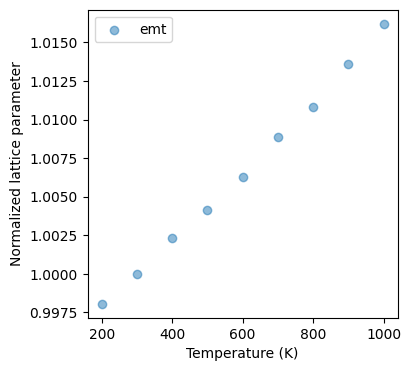

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from ase.io import read,Trajectory

time_step = 10.0  # Time step size between each snapshots recorded in traj
paths = Path("./output/ch6/").glob(f"**/fcc-Cu_3x3x3_NPT_{calc_type}_*K.traj")
path_list = sorted([ p for p in paths ])

# Temperature list extracted from the filename
temperature = [ float(p.stem.split("_")[-1].replace("K","")) for p in path_list ]
print("temperature = ",temperature)

# Compute lattice parameter
lat_a = []
for path in path_list:
    print(f"path = {path}")
    traj = Trajectory(path)
    vol = [ atoms.get_volume() for atoms in traj ]
    lat_a.append(np.mean(vol[int(len(vol)/2):])**(1/3))
    
print("lat_a = ",lat_a)

# Normalize relative to the value at 300 K
norm_lat_a = lat_a/lat_a[1]
print("norm_lat_a = ",norm_lat_a)

# Plot
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Temperature (K)')  # x axis label
ax.set_ylabel('Normalized lattice parameter')  # y axis label
ax.scatter(temperature[:len(norm_lat_a)],norm_lat_a, alpha=0.5,label=calc_type.lower())
ax.legend(loc="upper left")

The following plot is obtained by running the above code.

<figure style="text-align: center">
    <img src="../assets/ch6/Fig6-3_fcc-Cu_3x3x3_NPT_a_vs_T.png"/>
    <figcaption align = "center">Fig.6-3b. Normalized lattice parameter as a function of temperature.</figcaption>
    <figcaption align = "center">          Experimental data is taken from Reference [4].</figcaption>
</figure>
</br>

The results are further compared with the PFP calculations and, with the experimental data for reference. There is very good agreement for both the EMT and PFP data, while the PFP data appears to be closer to the experimental data with a small margin.

The coefficient of linear thermal expansion (CTE, $\alpha$) is calculated from the temperature dependence of the normalized lattice parameter using the following equation

$$
\frac{a(T)}{a_{RT}} = 1 + \alpha \cdot T
$$

where $\alpha$ is the coefficient of linear thermal expansion and $a(T)$ and $a_{RT}$ are the lattice constants at temperature $T$ and room temperature. 
The following is a summary of ASAP3-EMT, PFP, and experimental values [4].

||$\alpha$ ( $10^{-5}$ /K)|
|--|--|
|emt|2.23|
|pfp|2.13|
|exp|1.74|

Considering the calculation error, both calculation results are in reasonable agreement with the experimental values.

The coefficient of thermal expansion can be calculated by using MD simulations of the NPT ensemble in this way.

You may be thinking, "Can't we reproduce thermal expansion of liquids and gases in the same way?"
In principle, this is true, but at present there are only a limited number of models that can reproduce the thermal expansion of liquids and gases. 
There may be models that are specialized for specific liquids and gases in the classical force field, but when using first-principles calculations, the accuracy of intermolecular interactions in liquids and gases, which are much smaller than those in solids, is critical, and quantum chemical calculations with such accuracy are currently very difficult to perform. 
In particular, a large amount of computational data is required to create NNPs, and it is currently not very realistic to perform a large number of high-precision quantum chemical calculations. 
Therefore, the development of models with high accuracy in this area is expected in the future.

## [Advanced] Parrinello-Rahman barostat parameter dependency

When performing MD simulations in the NPT ensemble, a parameter called `pfactor` needs to be chosen.
It was explained that the appropriate value range is around 10$^6$ GPa$\cdot$fs$^2$ to 10$^7$ GPa$\cdot$fs$^2$. 
For your reference, the results when changing the value of `pfactor` are shown below. 
The calculation targets are the same fcc-Cu 3x3x3 unit cells as above, and the temperature is 300 K.

<figure style="text-align: center">
    <img src="../assets/ch6/Fig6-3_fcc-Cu_3x3x3_EMT_NPT_vol_vs_t_pfactor.png"/>
    <figcaption align = "center">Fig.6-3c. Time evolution of cell volume as a function of pfactor.</figcaption>
</figure>
</br>

When `pfactor` is small, the cell volume is oscillating at high speeds which is not desirable, and some regions have a mixture of high and low frequency oscillations making the system unstable.
As `pfactor` increases, the period of oscillation gradually increases, and the large volume changes at the beginning of the calculation are hardly noticeable. Although there is no clear cut indicator of which value of `pfactor` is correct, the median value seems to be as stable as ever, although small oscillations can be observed for values of 10$^6$ Ga$\cdot$fsec$^2$ or higher. 
Similarly, there is no well-defined reference for the upper limit, and since the larger the `pfactor`, the longer the oscillation period becomes and the more difficult it is to handle. 
A range between 10$^6$ and 10$^7$ seems appropriate for the above example.

##  [Advanced] Berendsen barostat parameter dependency

Here, we explain the calculation method using Berendsen barostat. 
The time evolution of pressure is calculated according to the following equation. 
(For details of the derivation, see reference [5]).


$$
\frac{d\mathbf{P}}{dt}=\frac{\mathbf{P}_o-\mathbf{P}}{\tau_P}
$$

It is clear from the above equation that the Berendsen pressure control method exponentially increases the pressure at each time in the system closer to the external pressure $\mathbf{P}_o$. 
Its speed is controlled by the time constant $\tau_P$.

At each MD step, the coordinates and cell vectors of each atom are scaled by a factor expressed by the following equation

$$
\mu_{ij}=\delta_{ij}-\frac{\Delta t}{3\tau_P}\beta_{ij}\big\{ P_{oij} - P_{ij}(t) \big\}
$$

Just as $\tau_T$ was a time constant when controlling a heat bath, an appropriate time constant ${\tau_P}$ must be set for the pressure control method. Let's look at an actual calculation example.

Using the [NPTBerendsen class](https://wiki.fysik.dtu.dk/ase/ase/md.html#module-ase.md.npt), the object defining the dynamics is written in the following form

In [6]:
from ase.md.nptberendsen import NPTBerendsen

dyn = NPTBerendsen(
    atoms,
    time_step*units.fs,
    temperature_K = temperature,
    pressure_au = 1.0 * units.bar,
    taut = 5.0 * units.fs,
    taup = 500.0 * units.fs,
    compressibility_au = 5e-7 / units.bar,
    logfile = log_filename,
    trajectory = traj_filename,
    loginterval=num_interval
)

`Inhomogeneous_NPTBerendsen`, which handles anisotropic pressure control, can be used with the same setting. (Simply relacing the class name from `NPTBerendsen` to `Inhomogeneous_NPTBerendsen` should work.) 
One difference between the two classes is that `Inhomogeneous_NPTBerendsen` accept mask argument can be set, i.e. setting `mask=(1, 1, 1)` allows the cell paramters a, b, and c can vary independently. 
If the element of this tuple is set to 0, the cell is fixed in that direction.

In addition to the calculation conditions such as temperature and pressure, it is necessary to set parameters called barostat time constant (`taup`, $\tau_P$) and compression ratio (`compressibility`, $\beta_T$).
The dependence of the time variation of the cell volume on each of these values will be checked using the example of fcc-Cu at 300 K. 
We will start with $\tau_P$.

<figure style="text-align: center">
    <img src="../assets/ch6/Fig6-3_fcc-Cu_3x3x3_EMT_NPTBerendsen_vol_vs_t_taup.png"/>
    <figcaption align = "center">Fig.6-3d. Time evolution of cell volume as a function of $\tau_P$.</figcaption>
</figure>
</br>

The smaller the time constant, the more unstable and violent the period of oscillation is. 
On the other hand, if the time constant is too large, the change is too gradual and it takes time to reach equilibrium. This is the same concept as the time constant of the heat bath method. 
For a system mechanically similar to fcc-Cu, the appropriate value for $\tau_P$ is around 10$^2$ fs to 10$^3$ fs due to the stability and convergence of the volume change.

Next is the dependence on $\beta_T$. The results are as follows.

<figure style="text-align: center">
    <img src="../assets/ch6/Fig6-3_fcc-Cu_3x3x3_EMT_NPTBerendsen_vol_vs_t_comp.png"/>
    <figcaption align = "center">Fig.6-3e. Time evolution of cell volume as a function of $\beta_T$.</figcaption>
</figure>
</br>

The smaller $\beta_T$ is, the slower the convergence is, and the higher the value, the more unstable it becomes. 
From the trend of the graph, 10$^{-7}$ to 10$^{-6}$fs seems to be a good range for $\beta_T$.

There is no strict guideline for choosing the values of $\tau_P$ and $\beta_T$. 
But it is better to have the sense of the trend when these values are changed by an order of magnitude. 

Finally, it should be noted that these values are only applicable to dense metallic materials such as fcc-Cu. If one wants to treat a completely different kind of materials (e.g., polymers, liquids, gases, etc.) with NPT ensemble, the appropriate range of values should be studied in advance. 
In general, it is recommended that great care be taken when working with new material systems, as omitting this preliminary study may lead to unintended results and extra time.

## Reference

[1] M.E. Tuckerman, "Statistical mechanics: Theory and molecular simulation", Oxford University Press (2010) ISBN 978-0-19-852526-4. https://global.oup.com/academic/product/statistical-mechanics-9780198525264?q=Statistical%20mechanics:%20Theory%20and%20molecular%20simulation&cc=gb&lang=en#

[2] Melchionna S. (2000) "Constrained systems and statistical distribution", Physical Review E 61 (6) 6165
https://journals.aps.org/pre/abstract/10.1103/PhysRevE.61.6165

[3] S. Melchionna, G. Ciccotti, B.L. Holian, "Hoover NPT dynamics for systems varying in shape and size", Molecular Physics, (1993) 78 (3) 533
https://doi.org/10.1080/00268979300100371

[4] F.C. Nix, D. MacNair, "NIST:The Thermal Expansion of Pure Metals: Copper, Gold, Aluminum, Nickel, and Iron"
https://materialsdata.nist.gov/handle/11256/32

[5] H. J. C. Berendsen, J. P. M. Postma, W. F. van Gunsteren, A. DiNola, and J. R. Haak, "Molecular dynamics with coupling to an external bath", J. Chem. Phys. (1984) 81 3684
https://aip.scitation.org/doi/10.1063/1.448118